# Inverse Geometry

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebook(s) with the code used to answer the questions.

**This laboratory (part I & II) can be completed over the next two lab sessions**

## Introduction

As we saw in the last laboratories, it is not obvious to get the tip of the finger to follow a given movement, such as a circle. Last laboratory you computed the forward kinematics of the robot, which provides the position of the fingertip given the measured joint angles. In this laboratory, we will use this function to do the inverse: find joint positions that will realize a desired fingertip position.

## Robot model
As a reminder, below is the kinematic model of the robot <img src="./3d_robot_model.png" width="500">

## Inverse Geometry / Inverse Kinematics Problem

The inverse geometry problem is the following: given a desired fingertip position (given in the S frame) $p_{SF} = (x_{des},y_{des}, z_{des})$, can we find joint angles $\theta_0$, $\theta_1$ and $\theta_2$ that would attain this position (if they exist)? Denoting $p_{FK}(\theta)$ the (forward kinematics) function that returns the fingertip position, given a joint angle configuration, our problem is to find the vector of joint angles $\theta$ that solves the equation
$$p_{FK}(\theta) = \begin{pmatrix} x_{des}\\ y_{des}\\ z_{des} \end{pmatrix}$$

**Key Take Away - Inverse Geometry determines the joint positions of the robot using the given tip location**

## Recasting the problem as an optimization problem

We saw in class that solutions to this equation are also solutions to the following optimization problem
$$\min_{\theta} \left(p_{FK}(\theta) - \begin{pmatrix} x_{des}\\ y_{des}\\ z_{des} \end{pmatrix}\right)^2$$
when we attain 0 as a minimum. When 0 is not attained, we get the "closest" possible solution, i.e. the attainable fingertip position that is closest to the desired one (when the desired one is not attainable).

In [1]:
# we import useful libraries
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy
from NYUFinger.sim import NYUFingerSimulator

# Set this to true and restart the kernel to use the real robot
use_real_robot = False

if use_real_robot:
    from NYUFinger.real import NYUFingerHardware
    robot = NYUFingerHardware()
else:
    robot = NYUFingerSimulator()

l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

**Note:** Rest the robot's sensors if you're using the real robot. Like what you did during previous weeks, put the robot into the zero position and run the following cell:

In [2]:
if use_real_robot:
    robot.reset_sensors()

In [3]:
### COPY PASTE YOUR FORWARD KINEMATICS FUNCTION HERE FROM LAB 2 (and other helper functions)
def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[:3, 3] = vector
    
    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[1:3, 1:3] = [[cos, -sin], [sin, cos]]
    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:3:2,0:3:2] = [[cos, sin], [-sin, cos]]
    
    ### we return the object
    return transform


def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:2,0:2] = [[cos, -sin], [sin, cos]]
    
    ### we return the object
    return transform


def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
    l0 = 0.3
    l1 = 0.16
    l2 = 0.16
    l3 = 0.014
    ###WRITE YOUR CODE HERE
    SH1=translate([l0, 0,0])@ rotateX(theta[0])
    H1H2= translate([0, 0, l3]) @ rotateZ(theta[1])
    H2K = translate([0, -l1, 0]) @ rotateZ(theta[2])
    KF = translate([0, -l2, 0])
    T_SH1=SH1
    T_SH2 = T_SH1 @ H1H2
    T_SK = T_SH2 @ H2K
    T_SF = T_SK @ KF
    ### we return the object
    return T_SF

## Question 1: Inverse Geometry

1. Write a function ``fingertip_position_error`` (cf. function sekeleton below) that takes as arguments ``joint_angles`` (as a vector) and ``desired_fingertip_position`` and return the squared distance between the fingertip position realized by joint_angles and the desired one, i.e. it returns $$\left(p_{FK}(\mathrm{joint\_angles}) - \mathrm{desired\_fingertip\_position}\right)^2$$

2. Write a function ``inverse_geometry`` that takes as an argument the desired fingertip position and returns a vector of joint angles that best realize this position (i.e. for which the fingertip position is as close as possible to the desired one). Use the ``minimize`` function from SciPy to do it - as seen in class.

3. Test that both of your functions work as expected. Explain what test you conducted and why it gives you confidence that the function works as expected.

In [4]:
import scipy.optimize


def fingertip_position_error(joint_angles, desired_fingertip_position):
    """
    fingertip_position_error function
    input joint_angles (as a 3D vector) and desired_fingertip_position (as a 3D vector)
    output the squared distance between the desired fingertip position and the one realized by joint_angles
    """
    p_fk = forward_kinematics(joint_angles)[0:3, 3]
    difference = p_fk-desired_fingertip_position
    
    return np.sum(np.power(difference, 2))


def inverse_geometry(desired_fingertip_position):
    """
    inverse geometry function
    input desired_fingertip_position (3D vector of desired position of the fingertip)
    output a vector of joint angles
    """
    bound = [(0, 2*np.pi),(0, 2*np.pi),(0, 2*np.pi)]
    result = scipy.optimize.minimize(fingertip_position_error, np.array([0, 0, 0]), args=(desired_fingertip_position), bounds=bound)
    return result.x

In [5]:
# Set a configuration vector and use the forward kinematics function to get the position. 
# Then feed the position into inverse_geometry and see if the result matches the inital configuration.
configs = [np.array([0,0,0]), np.array([0,1,0]), np.array([2*np.pi,0,1]), np.array([np.pi/2,np.pi/2,0]), np.array([np.pi/2,np.pi/2,1])]
for config in configs:
    pos = forward_kinematics(config)[0:3, 3]
    config_pred = inverse_geometry(pos)
    new_pos = forward_kinematics(config_pred)
    print(f"Actual configuration: {np.round(config,3)}\nPredicted configuration: {np.round(config_pred, 3)}")
    print(f"Initial position: {np.round(pos, 3)}\nPosition with predicted configuration: {np.round(new_pos, 3)[0:3, 3]}")
    print()

Actual configuration: [0 0 0]
Predicted configuration: [0. 0. 0.]
Initial position: [ 0.3   -0.32   0.014]
Position with predicted configuration: [ 0.3   -0.32   0.014]

Actual configuration: [0 1 0]
Predicted configuration: [0.    0.962 0.076]
Initial position: [ 0.569 -0.173  0.014]
Position with predicted configuration: [ 0.569 -0.173  0.014]

Actual configuration: [6.283 0.    1.   ]
Predicted configuration: [0. 0. 1.]
Initial position: [ 0.435 -0.246  0.014]
Position with predicted configuration: [ 0.435 -0.246  0.014]

Actual configuration: [1.571 1.571 0.   ]
Predicted configuration: [1.399 1.563 0.   ]
Initial position: [ 0.62  -0.014 -0.   ]
Position with predicted configuration: [ 0.62  -0.014  0.   ]

Actual configuration: [1.571 1.571 1.   ]
Predicted configuration: [1.571 1.571 1.   ]
Initial position: [ 0.546 -0.014  0.135]
Position with predicted configuration: [ 0.546 -0.014  0.135]



# Question 2: reaching controller
The code below generates 3 target ball locations (and displays them). Their locations are in the variable ball_position (a list containing 3D vectors of x,y,z positions). The goal is to modify all the code below (our typical control loop with a PD controller) such that the robot moves from its current position to each ball successively. To achieve this follow the steps below:

## Part 1:

1. Write an interpolate function to generate a smooth joint trajectory from a given initial and final joint positions in the desired time.  **NOTE : Read the linear time parametrization section in the jupyter notebook part II. Implement the linear_interpolate_trajectory() using the equations mentioned there.**  

In [ ]:
def linear_interpolate_trajectory(position_init, position_goal, t_init, t_goal, t):
    desired_position = (t - t_init)/(t_goal-t_init)*(position_goal-position_init) + position_init
    desired_velocity = (position_goal-position_init)/(t_goal-t_init)
    
    # we return the answer
    return desired_position, desired_velocity

: 

## Part 2:
2. Use the inverse geometry function to decide what the end joint angles should be for each ball (you can get them in the ball_positions array) and store them in another array called joint_positions_of_balls.
3. Now use the linear_interpolate_trajectory() function in the control loop to generate a smooth joint trajectory for the robot to move from its initial position to all the three balls, one after the other. The robot should reach each ball in T=3 seconds (i.e. go from initial configuration of the robot to ball 1 in 3 seconds, then move from ball 1 to ball 2 in 3 seconds and finally move from ball 2 to ball 3 in 3 seconds). 
4. Use the plotting function below to plot the motion of the fingertip in space and the joint position/velocity trajectories. How well does it go through the targets? Can you provide an explanation for this result?
5. Answer question 2. with the real robot

In [ ]:
### THE BALL POSITIONS ARE DEFINED HERE ###
# here we create a list of ball positions and display them if we are in simulation
ball_positions = [np.array([0.597,-0.056, 0.0]), np.array([0.521,0.12, 0.0]), np.array([0.3,-0.225, 0.0])]
joint_positions_of_balls = [inverse_geometry(ball_position) for ball_position in ball_positions]

if not use_real_robot:
    for ball in ball_positions:
        robot.add_ball(ball)

# we simulate for 9 seconds (3 seconds per goal)
run_time = 9.
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains
P = np.array([1.5, 1.5, 1.5])
D = np.array([0.01, 0.01, 0.01])

## we allocate a few vectors to collect data while we do the simulation
# we will store the sensor values (angular position and velocities)
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
# we will store the commands sent to the robot
desired_torques = np.zeros_like(measured_positions)
# we will store the desired joint trajectories that the PD controller follows
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
# we keep track of time
time = np.zeros([num_steps])
# we will store the end effector position (desired and measured)
measured_finger_position = np.zeros([num_steps,3])
desired_finger_position = np.zeros([num_steps,3])



# the time to reach a goal
time_to_goal = 3.0

# we use this to know which target we are currently aiming
ball_number = 0

# we measure the internal time for one target movement
t = 0.

prev_pos, _= robot.get_state()

## this is our main control loop ##
## we do the loop for num_steps ##
for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot.get_state()
    
    # we store these values for later use
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # save the current position of the fingertip using the FK function
    pose = forward_kinematics(q)
    measured_finger_position[i,:] = pose[0:3,3]
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO REACH ALL 3 TARGETS
    # the goal here is to compute q_des and dq_des that the PD controller will follow
    # you will need some internal logic to decide which ball you are currently targetting, etc.
    before = ball_number
    ball_number = int((dt*i)//time_to_goal)
    if before != ball_number:
        prev_pos, _= robot.get_state()
    
    ### WRITE YOUR CODE HERE ###
    # change this according to your needs so the robot moves according to your goals
    if ball_number == 0:
        q_des, dq_des = linear_interpolate_trajectory(prev_pos, joint_positions_of_balls[0], 0, time_to_goal, dt*i)
    else:
        q_des, dq_des = linear_interpolate_trajectory(prev_pos, joint_positions_of_balls[ball_number], 
                                                      time_to_goal*(ball_number-1), time_to_goal*ball_number, dt*i)

    
    # we save the desired positions/velocities for later plotting 
    desired_positions[i,:] = q_des
    desired_velocities[i,:] = dq_des
    
    ##PD controller
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    
    # we compute the desired torques as a PD controller
    joint_torques = P * error + D * d_error
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

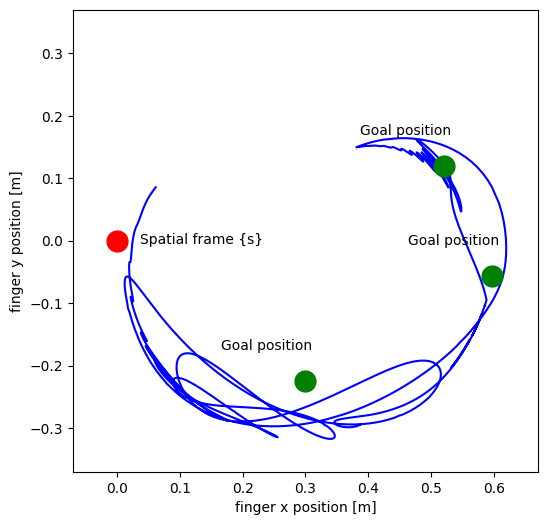

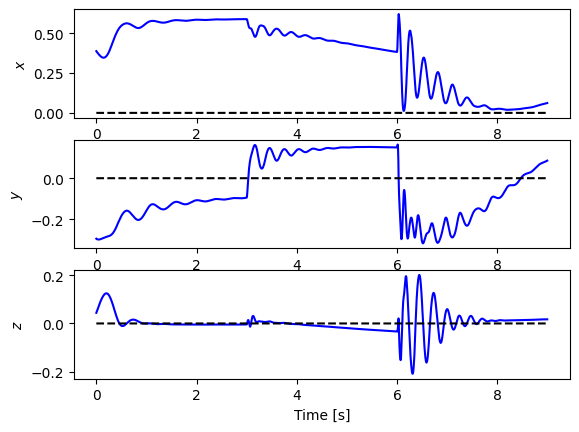

In [ ]:
def plot_finger_trajectory(finger_position, desired_finger_position, ball_positions):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,1], 'b')
    plt.plot(desired_finger_position[:,0],desired_finger_position[:,1], 'k')
    plt.xlabel('finger x position [m]')
    plt.ylabel('finger y position [m]')
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    for ball in ball_positions:
        plt.plot([ball[0]],[ball[1]],'o',markersize=15,color='g')
        ax.annotate('Goal position', xy=(ball[0]-0.2,0.05+ball[1]), xytext=(30,0), textcoords='offset points')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    
    fig = plt.figure()
    
    plt.subplot(3,1,1)
    plt.plot(time, measured_finger_position[:,0], 'b-', time, desired_finger_position[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,1,2)
    plt.plot(time, measured_finger_position[:,1], 'b-', time, desired_finger_position[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,1,3)
    plt.plot(time, measured_finger_position[:,2], 'b-', time, desired_finger_position[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')

plot_finger_trajectory(measured_finger_position, desired_finger_position, ball_positions)

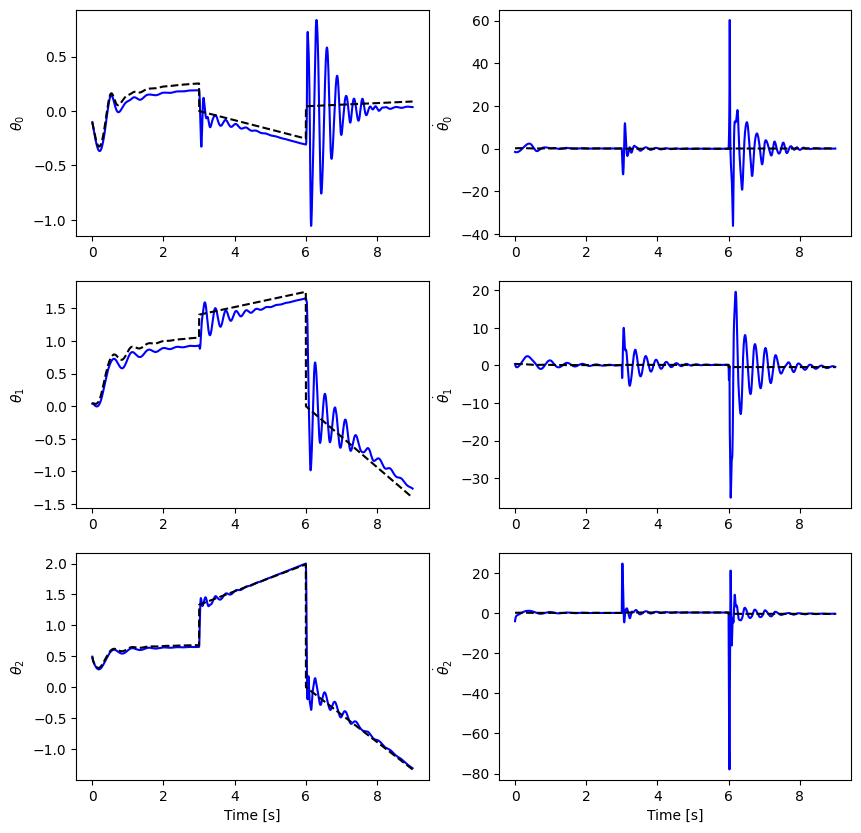

In [ ]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$\theta_0$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{\theta}_0$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, desired_positions, measured_velocities, desired_velocities)